In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**import libraries**

In [2]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L2
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_path="/kaggle/input/chest-ct-scan/train"
valid_path="/kaggle/input/chest-ct-scan/valid"
test_path="/kaggle/input/chest-ct-scan/test"

**Load Data**

In [6]:
# Define the paths to your image directories and their labels
paths_labels_train = {
    '/kaggle/input/chest-ct-scan/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,    # Path 1
    '/kaggle/input/chest-ct-scan/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,  # Path 2
    '/kaggle/input/chest-ct-scan/train/normal': 2,                                          # Path 3
    '/kaggle/input/chest-ct-scan/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3 # Path 4
}


In [7]:
# Define the paths to your image directories and their labels
paths_labels_val = {
    '/kaggle/input/chest-ct-scan/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,    # Path 1
    '/kaggle/input/chest-ct-scan/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,  # Path 2
    '/kaggle/input/chest-ct-scan/valid/normal': 2,                                          # Path 3
    '/kaggle/input/chest-ct-scan/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3 # Path 4
}

In [10]:
import cv2

In [11]:
# Initialize lists to hold images and labels
images = []
labels = []

# Loop through each class directory and label
for path, label in paths_labels_train.items():
    
    # Check if the path exists
    if os.path.exists(path):
        for image_file in os.listdir(path):
            img_path = os.path.join(path, image_file)

            # Read the image
            img = cv2.imread(img_path)

            # Check if the image was loaded successfully
            if img is not None:
                # Optionally resize the image to a common shape
                img = cv2.resize(img, (224, 224))  # Resize to 224x224 or your desired size

                # Convert the image to RGB (if using OpenCV)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Append the image and label to the lists
                images.append(img_rgb)
                labels.append(label)

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Optionally, create a DataFrame for easier handling
df = pd.DataFrame({'image': list(images), 'label': labels})

# Display the shape of the data
print(f"Loaded {len(images)} images.")


Loaded 613 images.


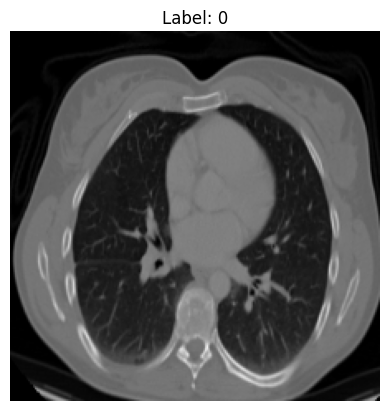

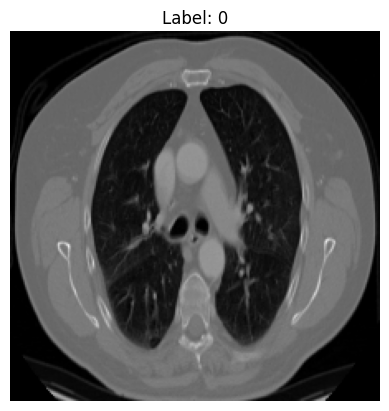

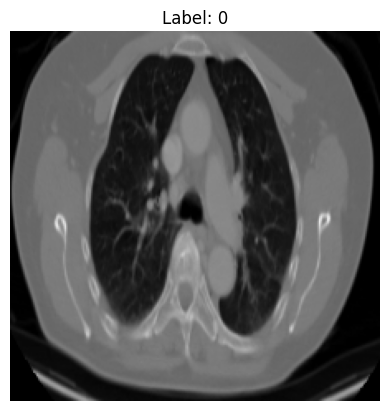

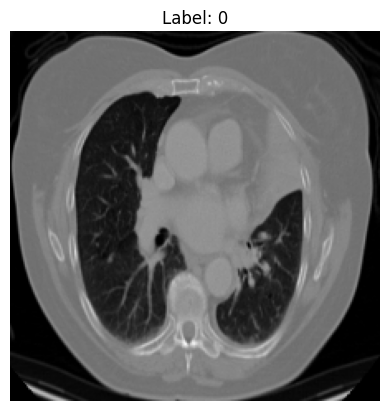

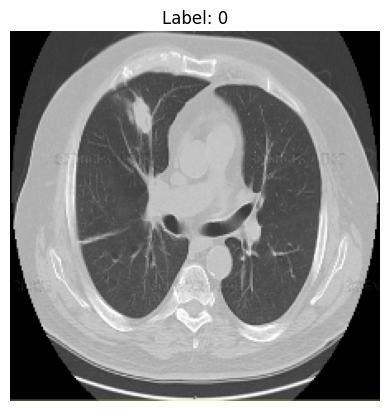

In [12]:
# Display a few images with their labels
num_images_to_show = 5
for i in range(min(num_images_to_show, len(images))):
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
    plt.show()


In [13]:
# Initialize lists to hold images and labels
images_val = []
labels_val = []

# Loop through each class directory and label
for path, label in paths_labels_val.items():
    
    # Check if the path exists
    if os.path.exists(path):
        for image_file in os.listdir(path):
            img_path = os.path.join(path, image_file)

            # Read the image
            img = cv2.imread(img_path)

            # Check if the image was loaded successfully
            if img is not None:
                # Optionally resize the image to a common shape
                img = cv2.resize(img, (224, 224))  # Resize to 224x224 or your desired size

                # Convert the image to RGB (if using OpenCV)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Append the image and label to the lists
                images_val.append(img_rgb)
                labels_val.append(label)

# Convert the lists to NumPy arrays
images_val= np.array(images_val)
labels_val= np.array(labels_val)

# Optionally, create a DataFrame for easier handling
df = pd.DataFrame({'image': list(images_val), 'label': labels_val})

# Display the shape of the data
print(f"Loaded {len(images_val)} images.")


Loaded 72 images.


In [14]:
images[0].shape , images[500].shape

((224, 224, 3), (224, 224, 3))

In [15]:
# Define augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [16]:
# For validation data, only normalize
val_datagen = ImageDataGenerator(rescale=1./255)

# Apply augmentation to in-memory arrays using `flow`
train_generator = train_datagen.flow(
    images, labels,
    batch_size=32
)

In [17]:
validation_generator = val_datagen.flow(
    images_val, labels_val,
    batch_size=32
)

**build model**

In [19]:
from tensorflow.keras import layers, models, Sequential

In [49]:
model=models.Sequential()

# Conv block1
model.add(layers.Conv2D(64, (3,3), activation="relu" , padding="same" , input_shape=(224,224,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64 , (3,3) , activation="relu" , padding="same"))
model.add(Dropout(rate = 0.5 , seed = 40))
model.add(layers.MaxPooling2D((2,2)))

# conv block2
model.add(layers.Conv2D(128, (3,3) , activation="relu" , padding="same" ))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128 , (3,3) , activation="relu" , padding="same"))
model.add(Dropout(rate = 0.5 , seed = 40))
model.add(layers.MaxPooling2D((2,2)))

# conv block3
model.add(layers.Conv2D(256, (3,3) , activation="relu" , padding="same" ))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256 , (3,3) , activation="relu" , padding="same"))
model.add(layers.Conv2D(256 , (3,3) , activation="relu" , padding="same"))
model.add(Dropout(rate = 0.5 , seed = 40))
model.add(layers.MaxPooling2D((2,2)))
          
# conv block4
model.add(layers.Conv2D(512, (3,3) , activation="relu" , padding="same" ))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512 , (3,3) , activation="relu" , padding="same"))
model.add(layers.Conv2D(512 , (3,3) , activation="relu" , padding="same"))
model.add(Dropout(rate = 0.5 , seed = 40))
model.add(layers.MaxPooling2D((2,2)))
          
# conv block5
model.add(layers.Conv2D(512, (3,3) , activation="relu" , padding="same" ))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512 , (3,3) , activation="relu" , padding="same"))
model.add(layers.Conv2D(512 , (3,3) , activation="relu" , padding="same"))
model.add(Dropout(rate = 0.5 , seed = 40))
model.add(layers.MaxPooling2D((2,2)))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(4096 , activation="relu"))
model.add(layers.Dense(4096 , kernel_regularizer = L2(0.15), bias_regularizer=L2(0.15), activation='relu'))
model.add(Dropout(rate = 0.5 , seed = 40))
model.add(layers.Dense(4 , activation="softmax"))

In [50]:
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,80

 Total params: 134,383,172 (512.63 MB)

 Trainable params: 134,330,052 (512.43 MB)

 Non-trainable params: 53,120 (207.50 KB)

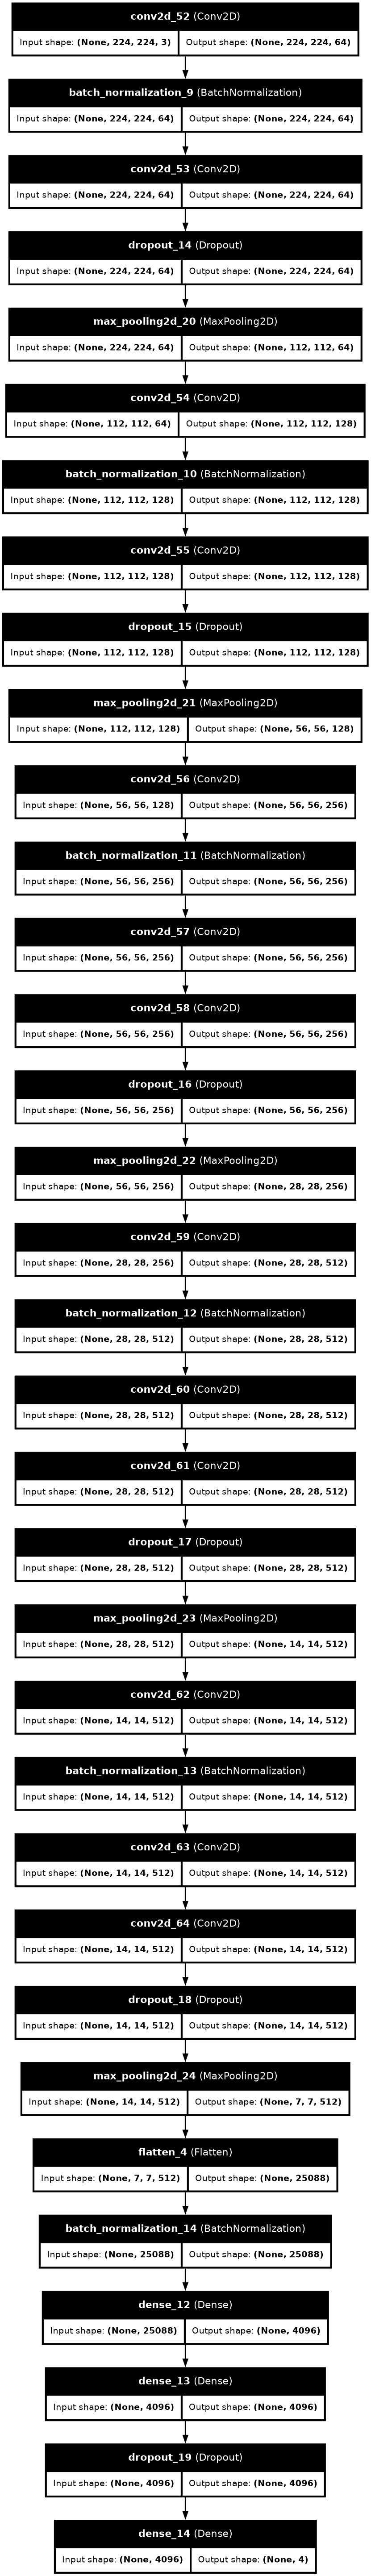

In [51]:
# Visualize the model without using kwargs
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,          # Change to True if you want to show the shapes
    show_dtype=False,
    show_layer_names=True,     # Change to True if you want to show layer names
    rankdir="TB",\
    expand_nested=False,
    dpi=100
)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [54]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01)]

In [55]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=my_callbacks
)

Epoch 1/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.3055 - loss: 471.8042

I0000 00:00:1729948769.453417     331 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 388 bytes spill stores, 388 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_8', 52 bytes spill stores, 52 bytes spill loads



20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 958ms/step - accuracy: 0.3060 - loss: 460.0536 - val_accuracy: 0.1806 - val_loss: 179.4827
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - accuracy: 0.4348 - loss: 115.7024 - val_accuracy: 0.2083 - val_loss: 75.1052
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 0.4504 - loss: 46.8711 - val_accuracy: 0.2083 - val_loss: 27.7031
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - accuracy: 0.5057 - loss: 21.6391 - val_accuracy: 0.2083 - val_loss: 23.9531
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.5369 - loss: 11.9368 - val_accuracy: 0.3194 - val_loss: 10.4017
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.4775 - loss: 7.5450 - val_accuracy: 0.3194 - val_loss: 7.3040
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.5845 - loss: 4.8357 - val_accuracy: 0.3194 - val_loss: 4.2156
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - accuracy: 0.5981 - loss: 3.7733 - val_a

In [56]:
# Evaluate the model with the validation generator
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3316 - loss: 7.0702
Validation loss: 7.280180931091309, Validation accuracy: 0.3194444477558136


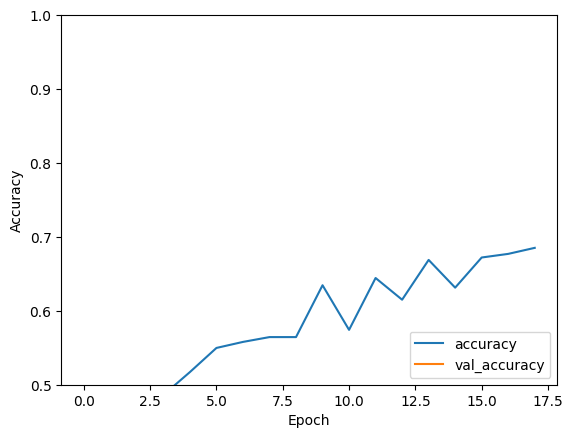

In [57]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [58]:
print("Number of batches in train_generator:", len(train_generator))

Number of batches in train_generator: 20


In [60]:

print("Number of training images:", len(images))
print("Number of validation images:", len(images_val))

Number of training images: 613
Number of validation images: 72


In [ ]:
# Fit the model
history = model.fit(images, labels , validation_data=(images_val,labels_val) , epochs=100 , batch_size=32,callbacks = my_callbacks)


In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(images_val, labels_val)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(images_val, labels_val, verbose=2)